# Changes:
1. Create a Pytorch Dataloader
2. Normalize input
3. Make the code runnable on Google Colab

In [20]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle

% matplotlib inline

In [3]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [4]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [5]:
def load_img_to_np(img_path, num_channel=1):
    images = []
    img_ids = []
    for filename in sorted(glob.glob(f'{img_path}/*.png')): #assuming png
        img_id = filename.split('\\')[-1].split('.')[0]
        img_ids.append(img_id)
        images.append(np.array(imageio.imread(filename), dtype=np.uint8).reshape(101,101,-1)[:,:,0:num_channel])
    return (np.r_[images], img_ids)

In [6]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img, cmap='gray')
    return img

In [7]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [8]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [9]:
def calc_raw_iou(a, b):
    if isinstance(a, torch.Tensor):
        a = a.detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.detach().numpy()
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
        
    return iou

In [10]:
def calc_mean_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    iou = calc_raw_iou(a, b)
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()

    return iou_mean

In [11]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [13]:
def plot_img_mask_pred(image, mask, pred=None):
    if pred is None:
        f, axarr = plt.subplots(1,2)
    else:
        f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(mask, cmap='gray')    
    axarr[0].grid()
    axarr[1].grid()    
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    if pred is not None:
        axarr[2].imshow(pred, cmap='gray')
        axarr[2].grid()
        axarr[2].set_title('Predicted Mask')
    plt.show()

In [14]:
class SigToBinary(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X.ge(0.5)
    

In [15]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return torch.clamp(out[:,:,:-1,:-1].squeeze(), 0.0, 1.0)

In [16]:
def adjust_predictions(black_img_mean, zero_mask_cut_off, mean_img, X, y_pred, y=None):
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = ((X+mean_img[None,:,:,None]).mean((1,2,3))<black_img_mean)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_iou(y_pred, y)}, IOU Score after:{calc_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [17]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [18]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

## Load Data

## Load train and test data from npy files or from raw images if npy files not exist.

In [19]:
try:
    print('Try loading data from npy and pickle files...')
    np_train_all = np.load('./data/np_train_all.npy')
    np_train_all_mask = np.load('./data/np_train_all_mask.npy')
    np_test = np.concatenate([np.load('./data/np_test_0.npy'), np.load('./data/np_test_1.npy')])
    with open('./data/misc_data.pickle', 'rb') as f:
        misc_data = pickle.load(f)
    print('Data loaded.')
except:
    print('npy files not found. Reload data from raw images...')
    np_train_all, np_train_all_ids = load_img_to_np('./data/train/images')
    np_train_all_mask, np_train_all_mask_ids = load_img_to_np('./data/train/masks')
    df_train_all_depth = pd.read_csv('./data/depths.csv').set_index('id')
    np_test, np_test_ids = load_img_to_np('./data/test/images')
    np.save('./data/np_train_all.npy', np_train_all)
    np.save('./data/np_train_all_mask.npy', np_train_all_mask)
    for k, v in enumerate(np.split(np_test,2)):
        np.save(f'./data/np_test_{k}.npy', v)
    misc_data = {'df_train_all_depth': df_train_all_depth,
                 'np_train_all_ids': np_train_all_ids,
                 'np_train_all_mask_ids': np_train_all_mask_ids,
                 'np_test_ids': np_test_ids}
    with open('./data/misc_data.pickle', 'wb') as f:
        pickle.dump(misc_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Data loaded.')

Try loading data from npy and pickle files...
npy files not found. Reload data from raw images...


NameError: name 'pickle' is not defined

In [24]:
    print('Try loading data from npy and pickle files...')
    np_train_all = np.load('./data/np_train_all.npy')
    np_train_all_mask = np.load('./data/np_train_all_mask.npy')
    np_test = np.concatenate([np.load('./data/np_test_0.npy'), np.load('./data/np_test_1.npy')])
    with open('./data/misc_data.pickle', 'rb') as f:
        misc_data = pickle.load(f)
    print('Data loaded.')

Try loading data from npy and pickle files...
Data loaded.


In [23]:
    misc_data = {'df_train_all_depth': df_train_all_depth,
                 'np_train_all_ids': np_train_all_ids,
                 'np_train_all_mask_ids': np_train_all_mask_ids,
                 'np_test_ids': np_test_ids}
    with open('./data/misc_data.pickle', 'wb') as f:
        pickle.dump(misc_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
np.array(misc_data['np_train_all_ids'])

array(['000e218f21', '003c477d7c', '00441f1cf2', ..., 'fff4eb4941',
       'fff6522bd1', 'fff987cdb3'], dtype='<U10')

## Train Val data split

In [ ]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [ ]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
X_train_mean_img = X_train.mean(0).astype(np.float32)

In [746]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X = self.np_img[idx] - self.mean_img
        #print(X.dtype)
        X = np.moveaxis(X, -1,0)
        
        X = np.pad(X, [(0, 0),(0, 1), (0, 1)], mode='constant')
        #print(X.dtype)
        if self.np_mask is None:
            y = np.zeros(101,101,1)
        else:
            y = self.np_mask[idx].clip(0,1)
        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float().squeeze()

        if self.transform:
            X = self.transform(X)
        #from boxx import g
        #g()
        return (X,y,d,idx)

In [748]:
data_params = {'batch_size': 60,
               'shuffle': True,
               'drop_last': False}

In [749]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img), **data_params)

In [750]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), **data_params)

In [751]:
test_dataLoader = DataLoader(SaltDataset(np_test, None, depth_test, X_train_mean_img), **data_params)

In [752]:
t = iter(train_dataLoader).__next__()

In [726]:
class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        #print(y_pred.requires_grad)
        #y_pred = torch.where(y_pred.ge(0.5), torch.tensor(1.0), torch.tensor(0.0))
        i = y_pred.mul(y)
        u = (y_pred + y) - i
        mean_iou = torch.mean(i.view(i.shape[0],-1).sum(1) / u.view(i.shape[0],-1).sum(1))
        iou_loss = 1 - mean_iou
        #from boxx import g
        #g()
        
        return iou_loss

## Create a Model

In [727]:
saltnet = SaltNet()

In [728]:
loss_fn = nn.BCELoss()
#loss_fn = IOU_Loss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [729]:
start = time.time()

In [730]:
TRAIN_MODE = True

In [731]:
list(saltnet.parameters())[0].sum()

tensor(-2.6569)

In [732]:
list(saltnet.parameters())[-1].grad

In [733]:
#X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=2)

In [734]:
max_epochs = 10
iter_count = 0
all_losses = []

In [1]:
np.mean(all_losses[-20:])

NameError: name 'np' is not defined

Loss is 0.671778162320455, IOU is 0.06166666666666667 at iter 2, Time: 10m 34s


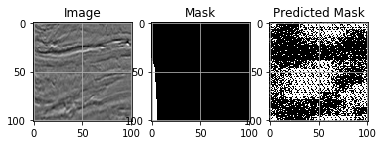

Loss is 0.6619205594062805, IOU is 0.15333333333333335 at iter 4, Time: 10m 47s


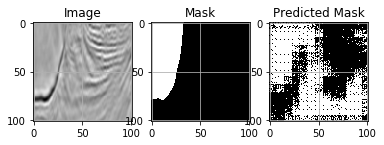

Loss is 0.650149771145412, IOU is 0.14333333333333334 at iter 6, Time: 11m 0s


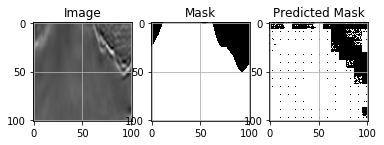

Loss is 0.6440305643611484, IOU is 0.12833333333333335 at iter 8, Time: 11m 15s


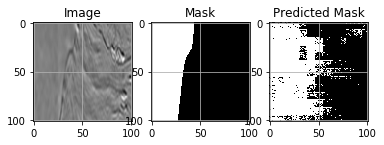

Loss is 0.6369162364439531, IOU is 0.13166666666666665 at iter 10, Time: 11m 30s


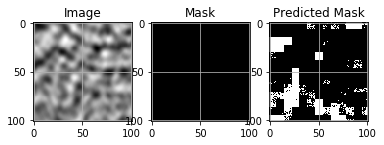

KeyboardInterrupt: 

In [772]:
if TRAIN_MODE:
    for epoch in range(max_epochs):
        
        for X_batch, y_batch, d_batch, X_id in train_dataLoader:
            #y_pred = torch.tensor(saltnet(X_batch).ge(0.5).float(), requires_grad=True)

            y_pred = saltnet(X_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch.float())
            loss.backward()
            optimizer.step()
            all_losses.append(loss.item())

            from boxx import g
            g()
            if iter_count % 2 == 0:
                iou_batch = calc_mean_iou(y_pred.ge(0.5), y_batch.float())
                print(f'Loss is {np.mean(all_losses[-20:])}, IOU is {iou_batch} at iter {iter_count}, Time: {timeSince(start)}')
                plot_img_mask_pred(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze(), y_pred[0].squeeze().gt(0.5))

            iter_count+=1

In [761]:
y_train[X_id[0]].squeeze().shape

(101, 101)

In [762]:
X_train[X_id[0]].squeeze()

array([[ 99,  99, 110, ..., 107, 135, 131],
       [ 99, 105, 116, ...,  96, 125, 131],
       [ 93, 108, 113, ...,  89, 116, 123],
       ...,
       [ 81,  81,  80, ...,  47,  60,  72],
       [ 83,  81,  81, ...,  52,  48,  68],
       [ 83,  81,  81, ...,  63,  40,  62]], dtype=uint8)

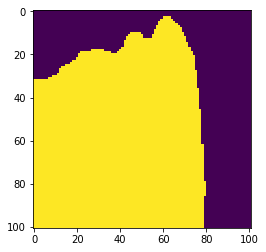

In [763]:
plt.imshow(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze())

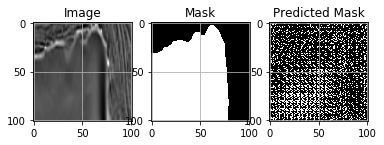

In [771]:
plot_img_mask_pred(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze(), y_pred[0].squeeze().gt(0.5))

In [768]:
plot_img_mask_pred(y_pred[0].squeeze().gt(0.5)

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 1,  0,  0,  ...,  0,  1,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  1,  1,  ...,  1,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  1],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.uint8)

In [694]:
X_train_mean_img.shape

(101, 101, 1)

In [645]:
calc_mean_iou(y_pred.ge(0.5), y_batch)

ValueError: operands could not be broadcast together with shapes (60,101,101) (60,101,101,1) 

In [597]:
X_batch.shape

torch.Size([60, 1, 102, 102])

In [626]:
saltnet(X_batch)

tensor([[[ 0.5321,  0.5148,  0.4644,  ...,  0.5051,  0.5026,  0.3797],
         [ 0.5514,  0.5332,  0.5455,  ...,  0.4692,  0.5647,  0.4677],
         [ 0.5151,  0.5462,  0.5312,  ...,  0.6047,  0.5421,  0.6679],
         ...,
         [ 0.4950,  0.5109,  0.4403,  ...,  0.4992,  0.5014,  0.5267],
         [ 0.4626,  0.5677,  0.5998,  ...,  0.5246,  0.5146,  0.5383],
         [ 0.4835,  0.4797,  0.5200,  ...,  0.4818,  0.5276,  0.5069]],

        [[ 0.5376,  0.4920,  0.4865,  ...,  0.4834,  0.5208,  0.5156],
         [ 0.5260,  0.5170,  0.5269,  ...,  0.5219,  0.5501,  0.4870],
         [ 0.5154,  0.5488,  0.4440,  ...,  0.4521,  0.4987,  0.5558],
         ...,
         [ 0.5037,  0.4802,  0.4766,  ...,  0.5227,  0.4766,  0.5670],
         [ 0.5387,  0.5326,  0.5508,  ...,  0.5437,  0.5076,  0.4781],
         [ 0.4935,  0.5004,  0.4862,  ...,  0.4407,  0.4722,  0.5282]],

        [[ 0.5378,  0.4782,  0.4606,  ...,  0.4358,  0.4712,  0.5211],
         [ 0.4833,  0.5279,  0.4879,  ...,  0

In [600]:
X_batch.dtype

torch.float64

In [603]:
X_batch.float().dtype

torch.float32

In [183]:
calc_mean_iou(y_pred.ge(0.5), y_batch)

0.40625

In [184]:
X_batch[1].shape

torch.Size([3, 102, 102])

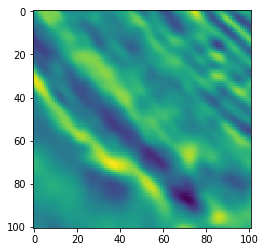

In [185]:
plt.imshow(X_batch[1][0].detach().numpy()[:101,:101]+mean_img)

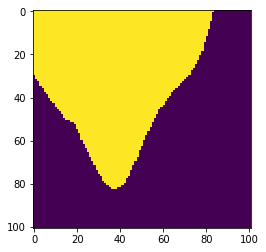

In [186]:
plt.imshow(y_batch[0])

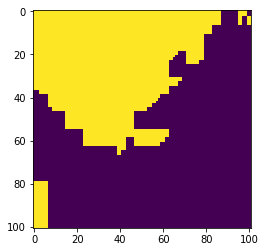

In [187]:
plt.imshow(y_pred.ge(0.5)[0])

In [126]:
y_pred_np = y_pred.ge(0.5).detach().numpy()

In [127]:
y_batch_np = y_batch.detach().numpy()

In [132]:
calc_raw_iou(y_pred_np, y_batch_np)

array([0.9992772 , 0.99713826])

In [133]:
calc_mean_iou(y_pred_np, y_batch_np)

1.0

In [112]:
y_batch.detach().numpy().shape

(2, 101, 101)

In [325]:
a = torch.rand(3,3, requires_grad=True)

In [326]:
a

tensor([[ 0.4054,  0.1794,  0.1386],
        [ 0.1540,  0.0732,  0.9761],
        [ 0.0375,  0.4661,  0.2143]])

In [327]:
b = torch.round(a)

In [328]:
b

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  0.]])

In [329]:
torch.relu??

Docstring: <no docstring>
Type:      builtin_function_or_method


In [ ]:
if TRAIN_MODE:
    state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
                 'optimizer': optimizer.state_dict() }
    ckp_name = f'saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

## Load checkpoint

In [34]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [35]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [189]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [190]:
assert saltnet.training == False

### Make Predictions on validation set

In [191]:
X_val_torch = format_train_data(X_val)

In [192]:
with torch.no_grad():
    y_val_pred = saltnet(X_val_torch)

y_val_pred = y_val_pred.ge(0.5).detach().numpy()

363


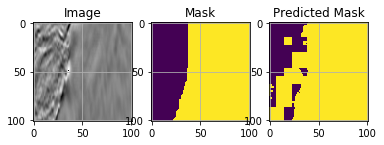

138


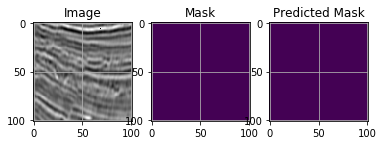

352


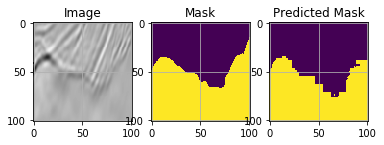

757


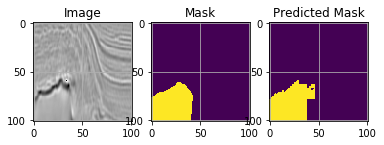

389


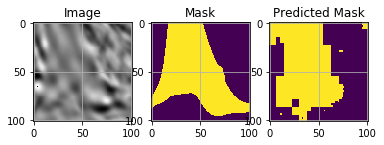

305


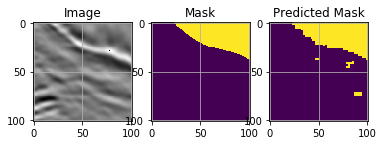

104


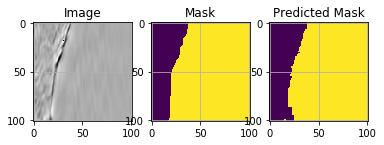

515


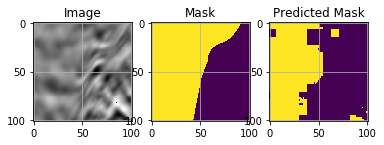

621


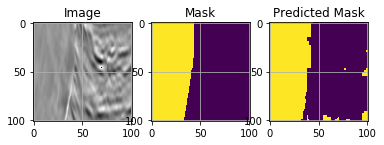

209


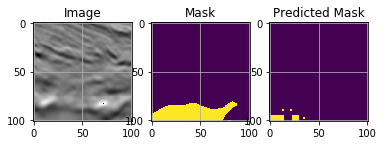

In [289]:
for i in range(10):
    rand_id = np.random.choice(len(X_val))
    print(rand_id)
    val_img = X_val[rand_id] + mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [194]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_val, y_val_pred, y_val)

IOU score before: 0.32862500000000006, IOU Score after:0.43250000000000005


In [248]:
img = df_train.iloc[0]['mask']

In [250]:
img.shape

(101, 101)

In [251]:
np.all(np.mod(img.sum(0),101)==0)

True

In [256]:
np.any(img) & np.all(np.mod(img.sum(0),101)==0)

False

In [284]:
df_train['striped'] = df_train.apply(lambda x: np.any(x['mask']) & np.all(np.mod(x['mask'].sum(0),101)==0), axis=1)

In [285]:
df_train.striped.value_counts()

False    3887
True      113
Name: striped, dtype: int64

In [286]:
df_train.loc[df_train.striped].index

Index(['00950d1627', '0280deb8ae', '06d21d76c4', '09152018c4', '09b9330300',
       '0b45bde756', '130229ec15', '15d76f1672', '182bfc6862', '1eaf42beee',
       ...
       'e73ed6e7f2', 'f0c401b64b', 'f19b7d20bb', 'f641699848', 'f6e87c1458',
       'f7380099f6', 'f75842e215', 'fb3392fee0', 'fb47e8e74e', 'febd1d2a67'],
      dtype='object', name='img_id', length=113)

In [276]:
df_depth = pd.read_csv('./data/depths.csv').set_index('id')

In [280]:
df_depth.loc['00950d1627'].z

922

File name:00950d1627, depth:922


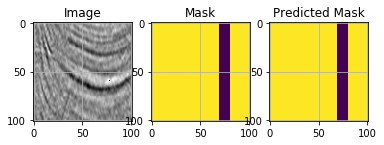

File name:0280deb8ae, depth:363


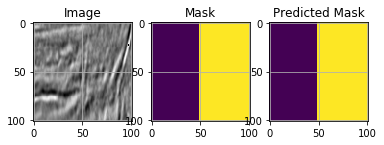

File name:06d21d76c4, depth:82


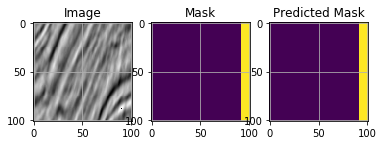

File name:09152018c4, depth:916


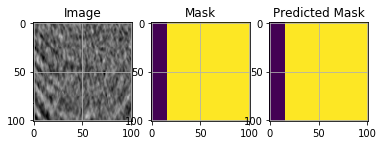

File name:09b9330300, depth:842


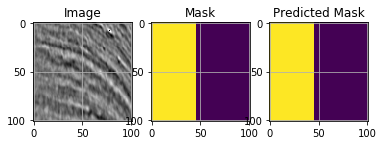

File name:0b45bde756, depth:92


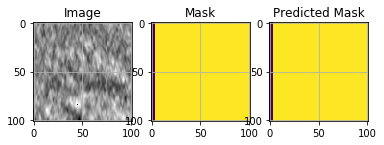

File name:130229ec15, depth:530


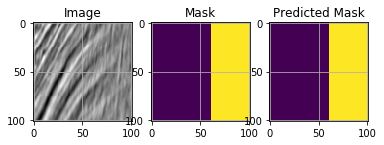

File name:15d76f1672, depth:494


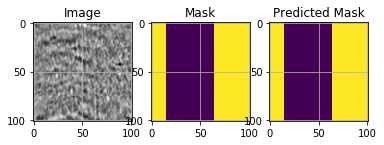

File name:182bfc6862, depth:363


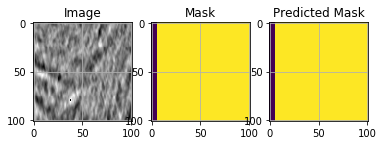

File name:1eaf42beee, depth:802


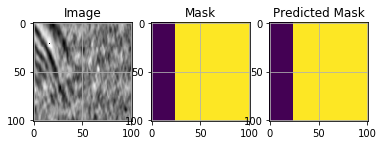

File name:23afbccfb5, depth:338


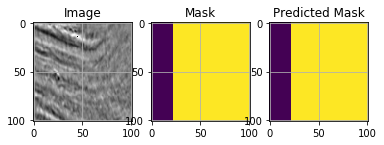

File name:24522ec665, depth:298


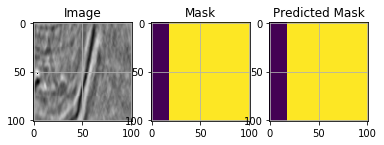

File name:285f4b2e82, depth:824


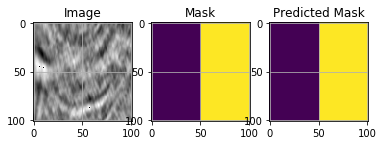

File name:2bc179b78c, depth:318


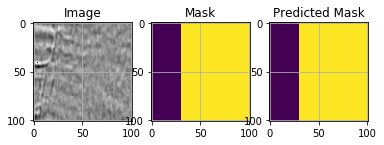

File name:2f746f8726, depth:297


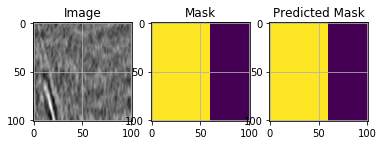

File name:33887a0ae7, depth:723


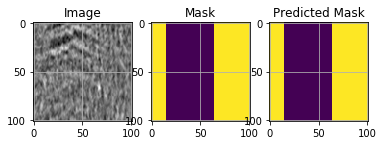

File name:33dfce3a76, depth:780


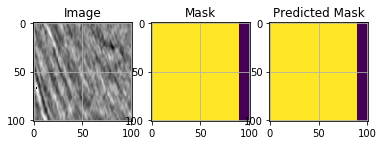

File name:3975043a11, depth:730


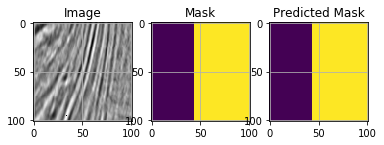

File name:39cd06da7d, depth:531


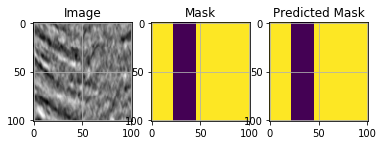

File name:3cb59a4fdc, depth:603


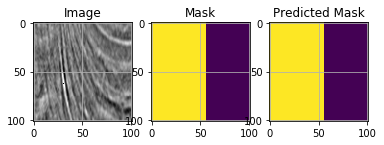

File name:403cb8f4b3, depth:661


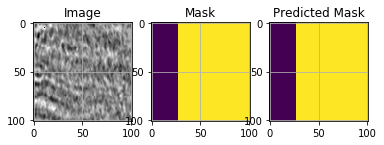

File name:483b35d589, depth:691


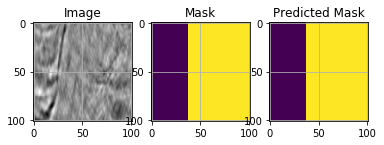

File name:49336bb17b, depth:385


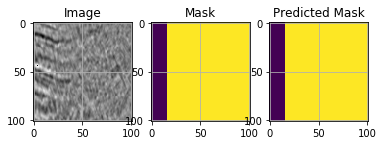

File name:4ef0559016, depth:700


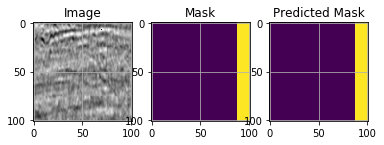

File name:4f5df40ab2, depth:514


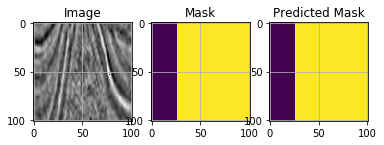

File name:4fbda008c7, depth:332


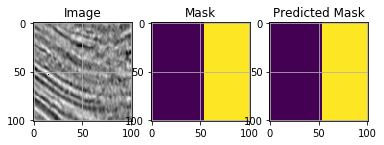

File name:4fdc882e4b, depth:955


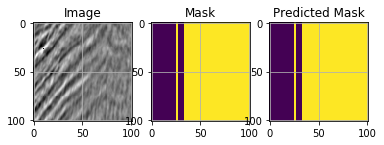

File name:50b3aef4c4, depth:116


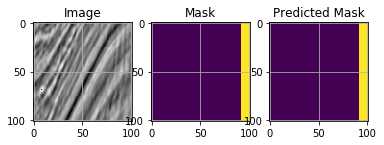

File name:50d3073821, depth:810


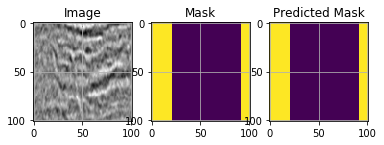

File name:52667992f8, depth:378


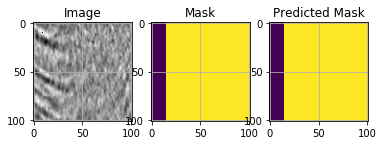

File name:52ac7bb4c1, depth:400


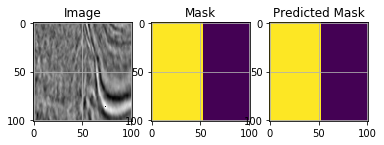

File name:53e17edd83, depth:738


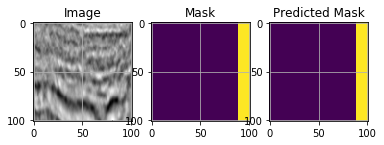

File name:56f4bcc716, depth:662


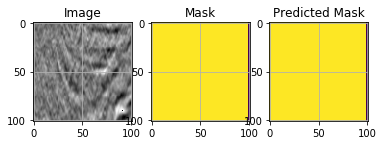

File name:58de316918, depth:901


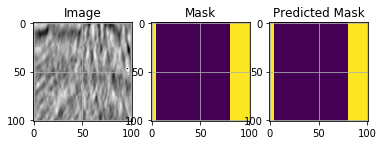

File name:5b217529e7, depth:446


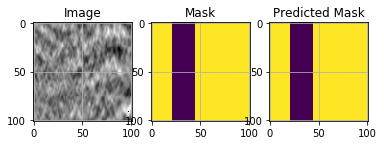

File name:5f98029612, depth:193


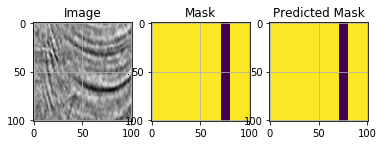

File name:608567ed23, depth:325


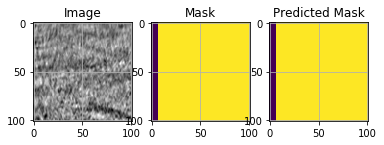

File name:62aad7556c, depth:926


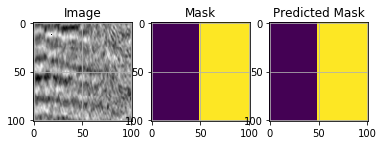

File name:62d30854d7, depth:427


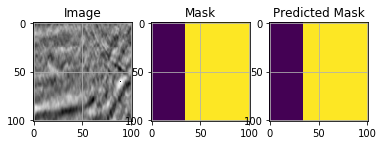

File name:640ceb328a, depth:612


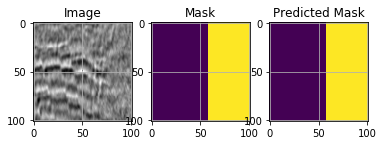

File name:6460ce2df7, depth:746


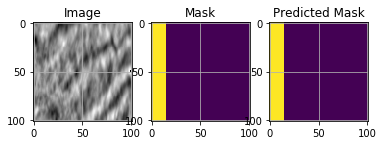

File name:6bc4c91c27, depth:655


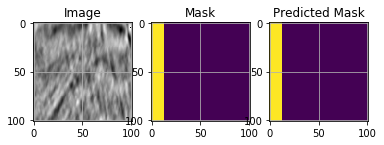

File name:71f7425387, depth:944


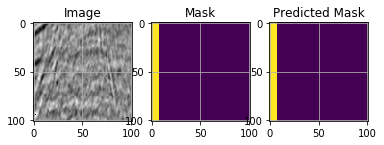

File name:7845115d01, depth:343


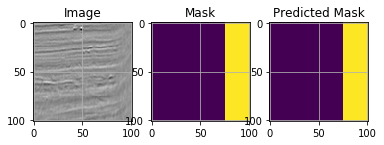

File name:7c0b76979f, depth:117


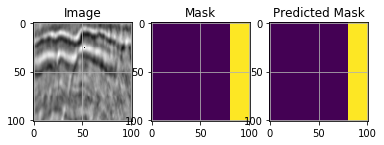

File name:7deaf30c4a, depth:365


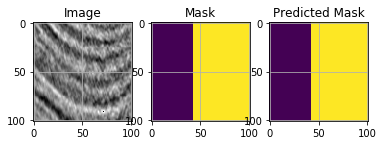

File name:7f0825a2f0, depth:136


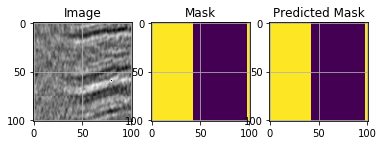

File name:80a458a2b6, depth:94


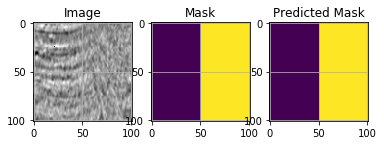

File name:81fa3d59b8, depth:857


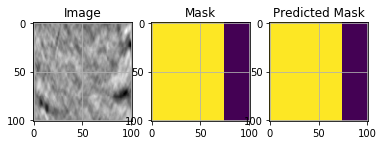

File name:834861f1b6, depth:461


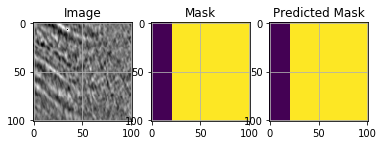

File name:8367b54eac, depth:615


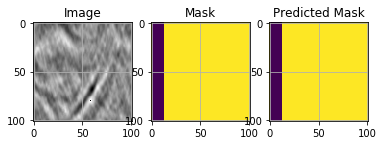

File name:849881c690, depth:701


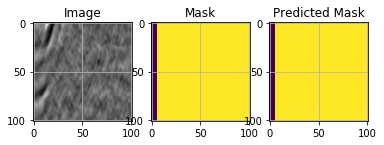

File name:876e6423e6, depth:882


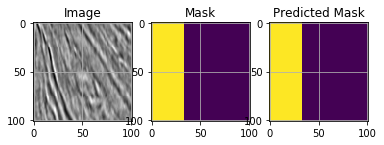

File name:87afd4b1ca, depth:668


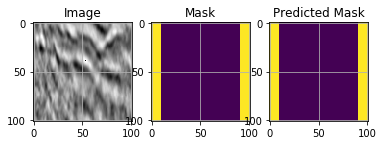

File name:88a5c49514, depth:948


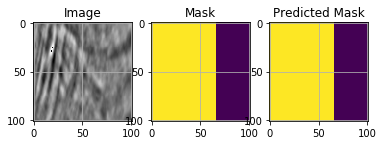

File name:9067effd34, depth:870


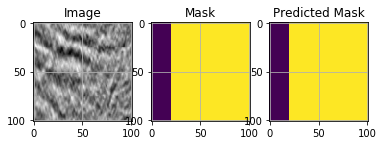

File name:90720e8172, depth:742


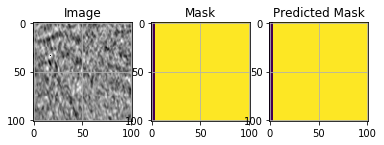

File name:916aff36ae, depth:946


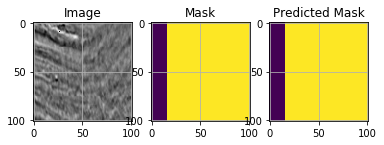

File name:919bc0e2ba, depth:352


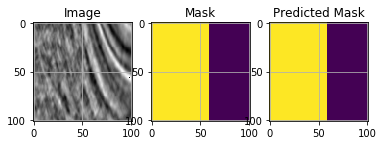

File name:93a1541218, depth:294


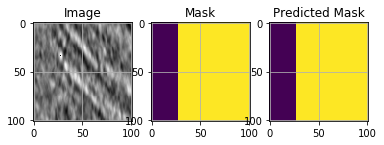

File name:95f6e2b2d1, depth:141


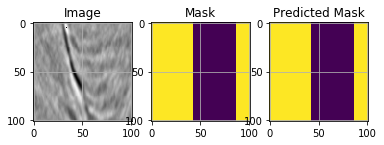

File name:96216dae3b, depth:166


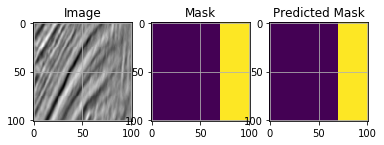

File name:96523f824a, depth:752


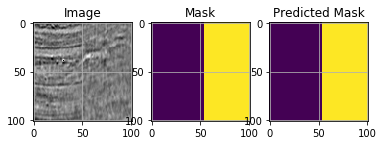

File name:99ee31b5bc, depth:241


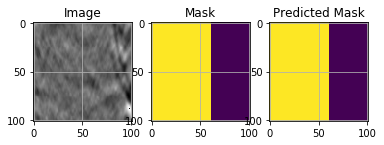

File name:9a4b15919d, depth:259


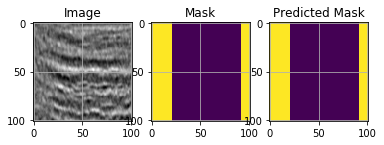

File name:9b29ca561d, depth:349


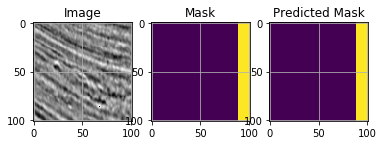

File name:9eb4a10b98, depth:581


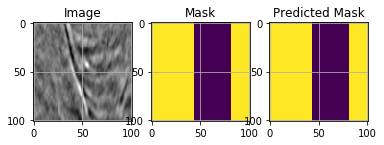

File name:a266a2a9df, depth:794


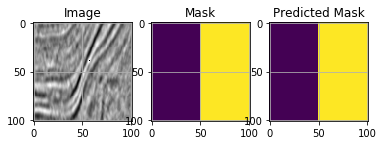

File name:a6625b8937, depth:944


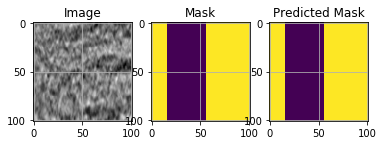

File name:a9ee40cf0d, depth:438


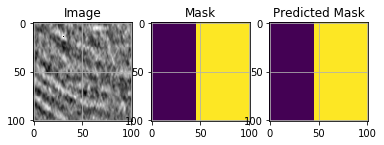

File name:ad2fa649f7, depth:858


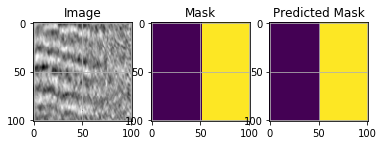

File name:aeba5383e4, depth:352


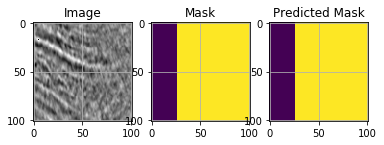

File name:b1be1fa682, depth:95


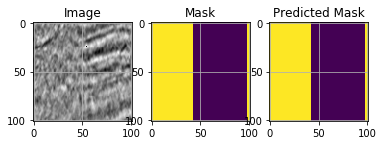

File name:b24d3673e1, depth:945


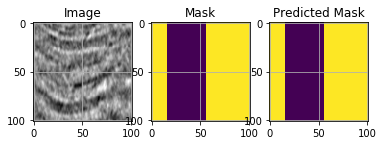

File name:b35b1b412b, depth:737


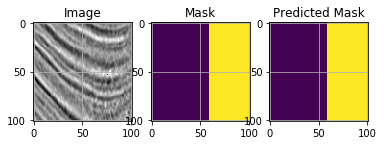

File name:b525824dfc, depth:628


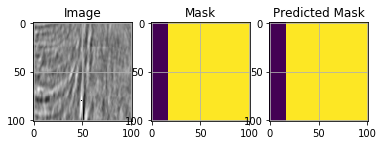

File name:b63b23fdc9, depth:194


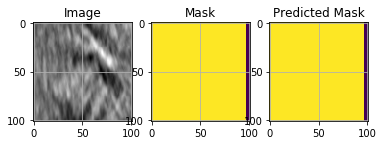

File name:b7b83447c4, depth:87


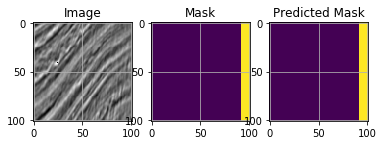

File name:b8a9602e21, depth:527


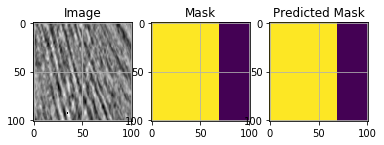

File name:ba1287cb48, depth:566


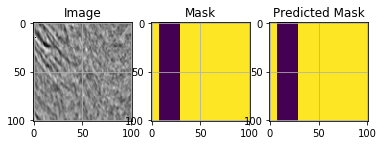

File name:baac3469ae, depth:491


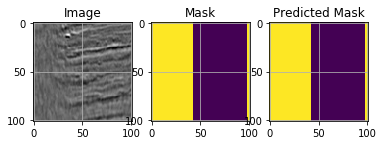

File name:be18a24c49, depth:314


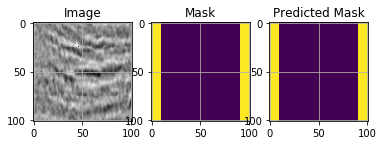

File name:be7014887d, depth:715


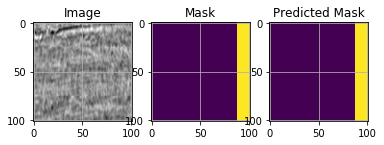

File name:be90ab3e56, depth:407


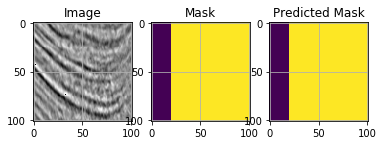

File name:bfa7ee102e, depth:844


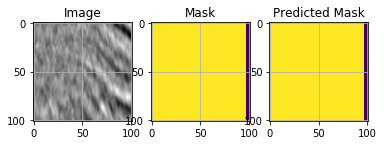

File name:bfbb9b9149, depth:802


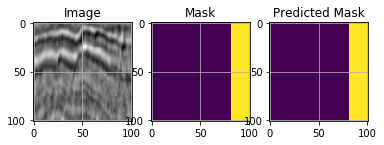

File name:c27409a765, depth:766


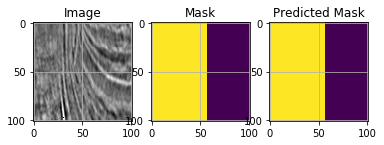

File name:c2973c16f1, depth:869


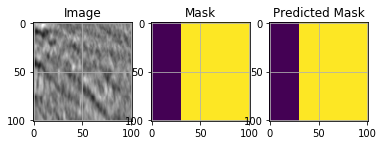

File name:c387a012fc, depth:478


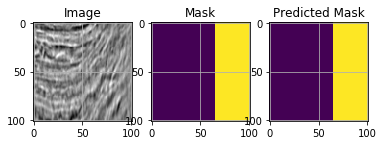

File name:c83d9529bd, depth:822


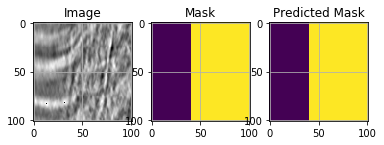

File name:c98dfd50ba, depth:558


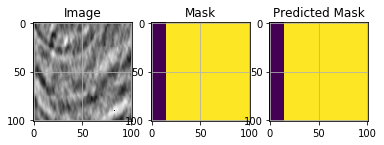

File name:caccd6708f, depth:747


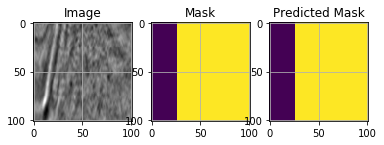

File name:cb4f7abe67, depth:183


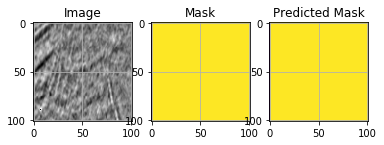

File name:cef03959d8, depth:221


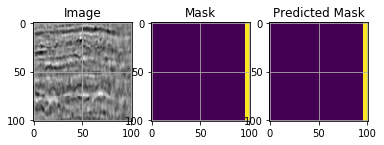

File name:d0bbe4fd97, depth:847


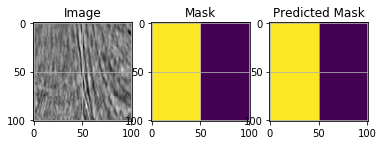

File name:d4d2ed6bd2, depth:330


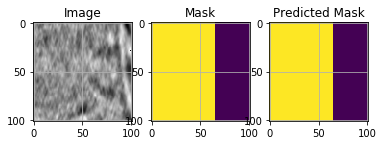

File name:d4d34af4f7, depth:114


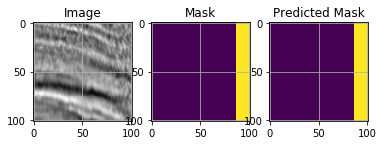

File name:d9a52dc263, depth:609


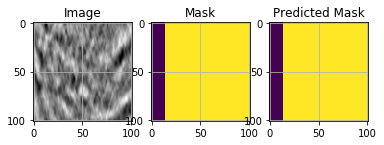

File name:dd6a04d456, depth:446


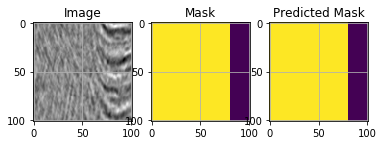

File name:ddcb457a07, depth:681


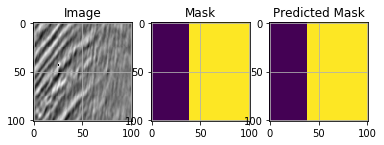

File name:de7202d286, depth:518


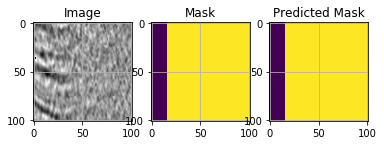

File name:e12cd094a6, depth:758


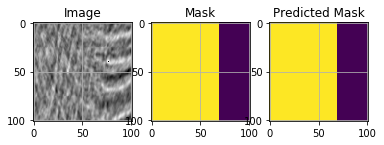

File name:e6e3e58c43, depth:448


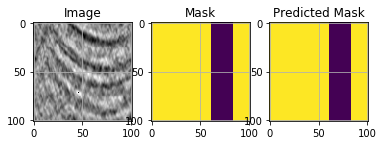

File name:e73ed6e7f2, depth:887


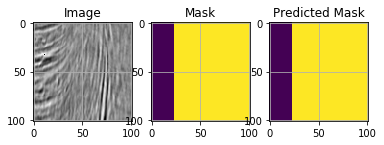

File name:f0c401b64b, depth:625


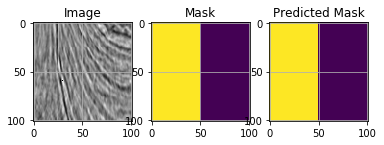

File name:f19b7d20bb, depth:451


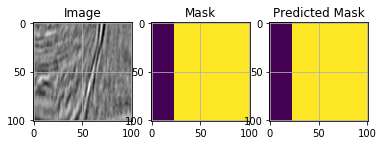

File name:f641699848, depth:552


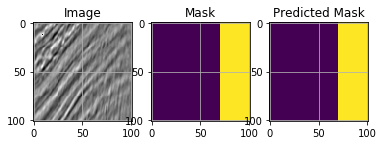

File name:f6e87c1458, depth:128


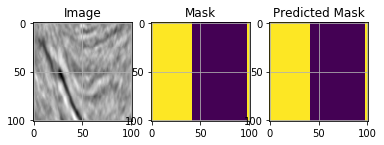

File name:f7380099f6, depth:796


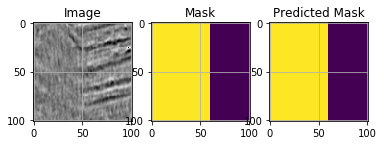

File name:f75842e215, depth:453


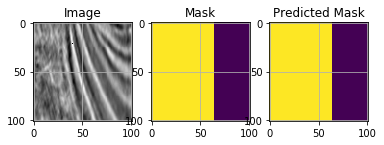

File name:fb3392fee0, depth:261


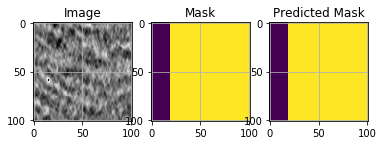

File name:fb47e8e74e, depth:757


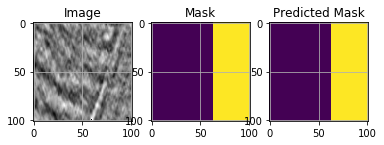

File name:febd1d2a67, depth:211


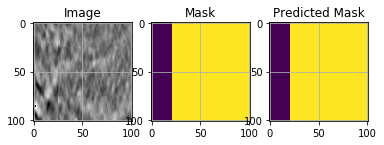

In [281]:
for i in df_train.loc[df_train.striped].index:
    #rand_id = np.random.choice(len(X_val))
    print(f'File name:{i}, depth:{df_depth.loc[i].z}')    
    img = df_train.img[i] + mean_img[:,:,None]
    mask = df_train['mask'][i]
    mask_pred = mask
    plot_img_mask_pred(img, mask, mask_pred)

## Make predictions on test set

In [50]:
y_test_pred_raw = []

In [51]:
for x in np.split(X_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [52]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [53]:
y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

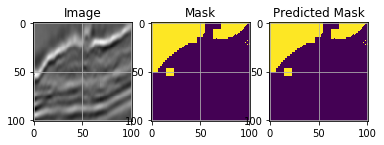

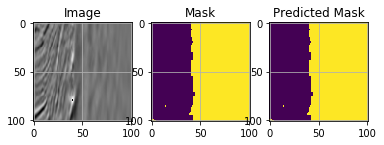

In [84]:
for i in range(2):
    rand_id = np.random.choice(len(X_test))
    #print(rand_id)
    img = X_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id]
    plot_img_mask_pred(img, mask_pred, mask_pred)

### Adjust predictions

In [55]:
y_test_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_test, y_test_pred)

### Encode predictions using RLE(Run Length Encoding) method

In [56]:
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [57]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [58]:
df_test_rle.columns = ['id', 'rle_mask']

In [59]:
df_test_rle[df_test_rle.rle_mask==''].shape

(6665, 2)

In [60]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)